Unsupervised Learning - Dimensionality Reduction

# In Depth: Principal Component Analysis

Up until now, we have been looking in depth at supervised learning estimators: those estimators that predict labels based on labeled training data. Here we begin looking at several unsupervised estimators, which can highlight interesting aspects of the data without reference to any known labels.

In this section, we explore what is perhaps one of the most broadly used of unsupervised algorithms, principal component analsysis (PCA). PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction and engneering, and much more. After a brief conceptual discussion of the PCA algorithm, we will see a couple examples of these further applications. We begin with the standard imports:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Introduction Principal Component Analysis

Principal component analysis is a fast and flexible unsupervised method for **dimensionality reduction** in data. Its behavior is easiest to visualize by looking at a two-dimensional dataset. Consider the following 200 points:

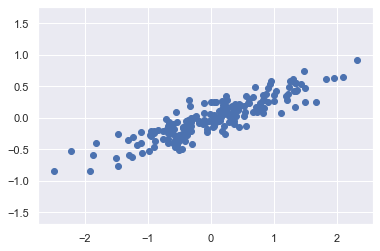

In [2]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

By eye, it is clear that there is a nearly linear relationship between the x and y variables. This reminiscent of the linear regression data we explored before, but the problem setting here is slightly different: rather than attempting to **predict** the y values from the x values, the unsupervised learning problem attempts to learn about the relationship beteen the x and y vales.

In principal component analysis, one quantifies thsi relationship by finding a list of the **principal axes** in the data, and using those axes to desribe the dataset. Using Scikit-Learn's `PCA` estimator, we can compute this as follows:

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

The fit learns some quantities for the data, most importantly the "components" and "explained variance":

In [4]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [5]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


To see what these numbers mean, let's visualize them as vectors over the uinput data, using the "components" to define the driecton of th vector, and the "explained variance" to define the squared-length of the vector:

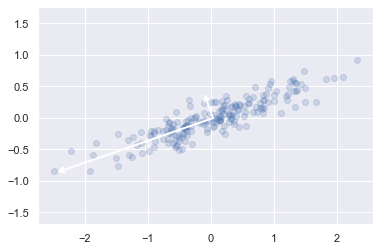

In [6]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

These vectors represent the **principal axes** of the data, and the length show in the figure above is an indication of how **important** that axis is in describing the distribution of the data - more precisely, it is a measure of the variance of the data when projected onto that axis. The projection of each data point onto the principal axes are the **principal components** of the data. 

If we plot these principal components beside the original data, we see the plots shown below:

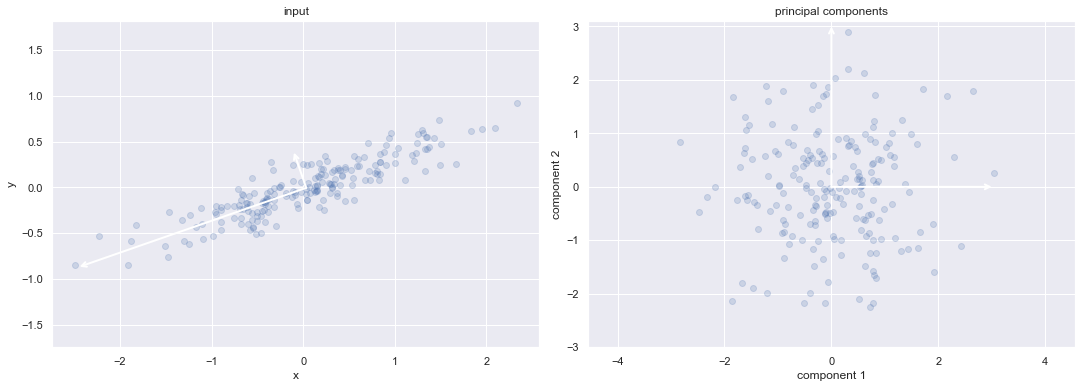

In [8]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
pca = PCA(n_components=2, whiten=True)
pca.fit(X)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# plot data
ax[0].scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax[0])
ax[0].axis('equal');
ax[0].set(xlabel='x', ylabel='y', title='input')

# plot principal components
X_pca = pca.transform(X)
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)
draw_vector([0, 0], [0, 3], ax=ax[1])
draw_vector([0, 0], [3, 0], ax=ax[1])
ax[1].axis('equal')
ax[1].set(xlabel='component 1', ylabel='component 2',
          title='principal components',
          xlim=(-5, 5), ylim=(-3, 3.1))

fig.savefig('figures/05.09-PCA-rotation.png')

This transformtion from data axes to principal axes is an **affine transformation** which basically means it is composed of a translation, roration, and uniform scaling. 

Which this alrorithm 

## PCA as Noise Filtering

## Example: Eigenfaces

## Principal Component Analaysis Summary